<h1><center><font size="6">Cats or Dogs - using CNN with Transfer Learning</font></center></h1>


<center><img src="https://www.theladders.com/wp-content/uploads/dog-cat-190709-1000x563.jpg" width="900"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages and set parameters</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Validation accuracy and loss</a>  
    - <a href='#54'>Validation accuracy per class</a>  
- <a href='#6'>Prepare submission</a>     
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>



# <a id="1">Introduction</a>  


## Dataset

The **train** folder contains **25,000** images of **dogs** and **cats**. Each image in this folder has the label as part of the filename. The **test** folder contains **12,500** images, named according to a numeric id.  
For each image in the test set, you should predict a probability that the image is a dog (**1** = **dog**, **0** = **cat**).


## Method

For the solution of this problem we will use a pre-trained model, ResNet-50, replacing only the last layer.

# <a id="2">Load packages</a>

In [ ]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50, InceptionV3, ResNet50V2, EfficientNetB1
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 8GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Upload dataset dari Google Drive

Folder: dataset-cat-dog-25k-resnet, silakan download dataset dan upload ke drive masing-masing!

Link drive dataset: https://drive.google.com/drive/folders/1y-zW16WLuEJ574z_x1DVKJVIx_KzsLD2?usp=sharing

In [ ]:
# https://drive.google.com/file/d/1-3GXP5M6jZPABnepwpzIu_9k36D9vWob/view?usp=sharing
# !gdown 1-3GXP5M6jZPABnepwpzIu_9k36D9vWob /content/dataset-cat-dog-25k-resnet --folder
# https://drive.google.com/file/d/1-3wvZrrU7bYv53pUqD-GrrZFSgxpxN5H/view?usp=sharing
# !gdown 1-3wvZrrU7bYv53pUqD-GrrZFSgxpxN5H /content/dataset-cat-dog-25k-resnet --folder

!gdown https://drive.google.com/drive/folders/1-1-PbnZc0KDhzWGtGtg2c1-HUizXBiPy -O /content/dataset-cat-dog-25k-resnet --folder

Retrieving folder list
Processing file 1-3GXP5M6jZPABnepwpzIu_9k36D9vWob test.zip
Processing file 1-3wvZrrU7bYv53pUqD-GrrZFSgxpxN5H train.zip
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-3GXP5M6jZPABnepwpzIu_9k36D9vWob
To: /content/dataset-cat-dog-25k-resnet/test.zip
100% 284M/284M [00:01<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3wvZrrU7bYv53pUqD-GrrZFSgxpxN5H
To: /content/dataset-cat-dog-25k-resnet/train.zip
100% 570M/570M [00:02<00:00, 194MB/s]
Download completed


## Parameters

Here we set few parameters used in the model. The image size is **224**.    
The images are stored in two folders, **train** and **test**.  
There are two image classes: **Dog** and **Cat**.  
We will use a subset of the training data set (**20,000** images).  From the training set, **75%** will be used for training, **25%** for validation.  
A pre-trained model from **ResNet-50** will be used.  
A number of **10** epochs will be used for training.  



In [ ]:
TEST_SIZE = 0.5
RANDOM_STATE = 2022
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 2
SAMPLE_SIZE = 25000
PATH = '/content/dataset-cat-dog-25k-resnet'
#PATH = 'drive/MyDrive/dataset-cat-dog-resnet50/'
TRAIN_FOLDER = '/content/train'
TEST_FOLDER =  '/content/test'
IMG_SIZE = 128
# RESNET_WEIGHTS_PATH = 'drive/MyDrive/dataset-cat-dog-25k-resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# <a id="3">Read the data</a>

We set the train image list.   
Setting the **SAMPLE_SIZE** value we can reduce/enlarge the size of the training set.    
Currently **SAMPLE_SIZE** is set to **20,000**.


In [ ]:
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

In [ ]:
import zipfile
with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall(".")

In [ ]:
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall(".")

In [ ]:
train_image_list = os.listdir("train/")[0:SAMPLE_SIZE]
test_image_list = os.listdir("test/")

We set a function for parsing the image names to extract the first 3 letters from the image names, which gives the label of the image. It will be either a cat or a dog. We are using one hot encoder, storing [1,0] for **cat** and [0,1] for **dog**.

In [ ]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

We are defining as well a function to process the data (both train and test set). 

In [ ]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

# <a id="4">Data exploration</a>


## <a id="41">Class distribution</a>

Let's inspect the train data to check the **cat**/**dog** distribution.   We show first the split in the reduced train data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


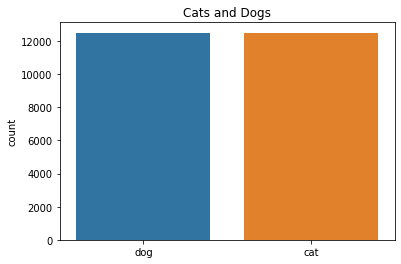

In [ ]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

Let's show also the class distribution in the full train data set.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


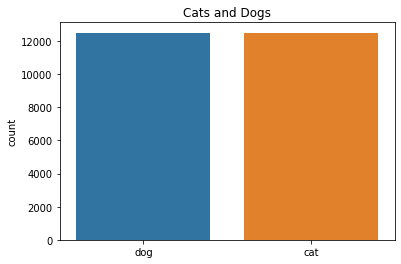

In [ ]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))

## <a id="42">Images samples</a>

Let's represet some of the images. We start with a selection from the train set. We will show the first 25 images from the train set.

First,  we process the train data, reading the images and creating a table with images and labels. If the data is trom train set, the label is the one calculated with one hot encoding; if the data is from test set, the label will be the image number.

In [ ]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 25000/25000 [00:54<00:00, 457.75it/s]


Then, we plot the image selection.

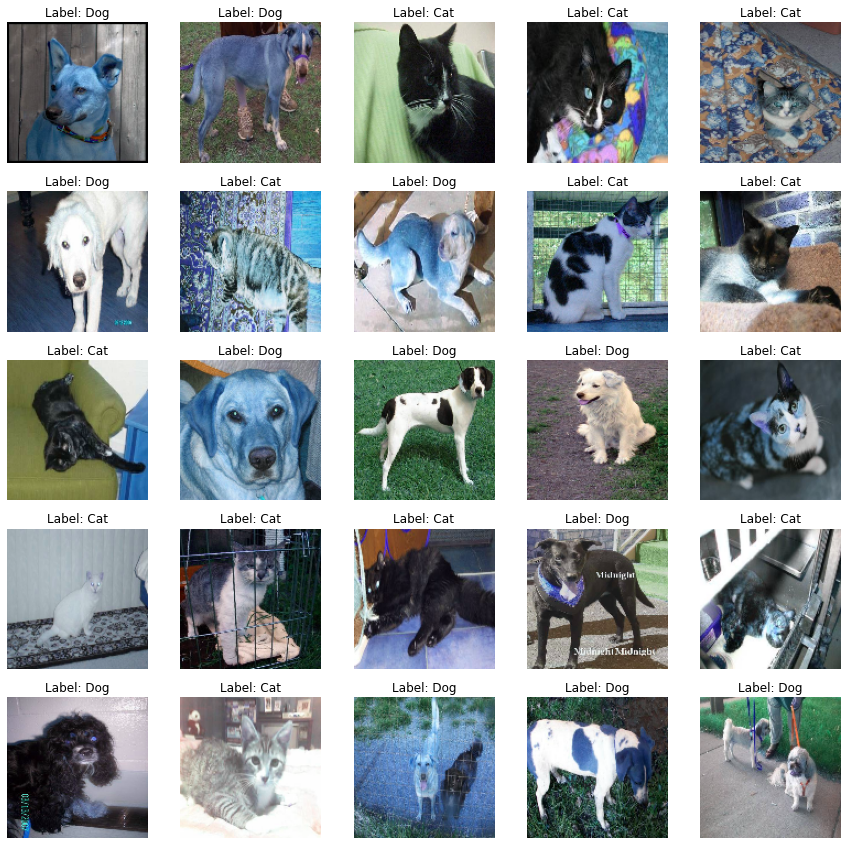

In [ ]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

Let's also show a selection of the train set. We prepare the test set.

In [ ]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 12500/12500 [00:26<00:00, 477.42it/s]


Then, we show a selection of the test set.

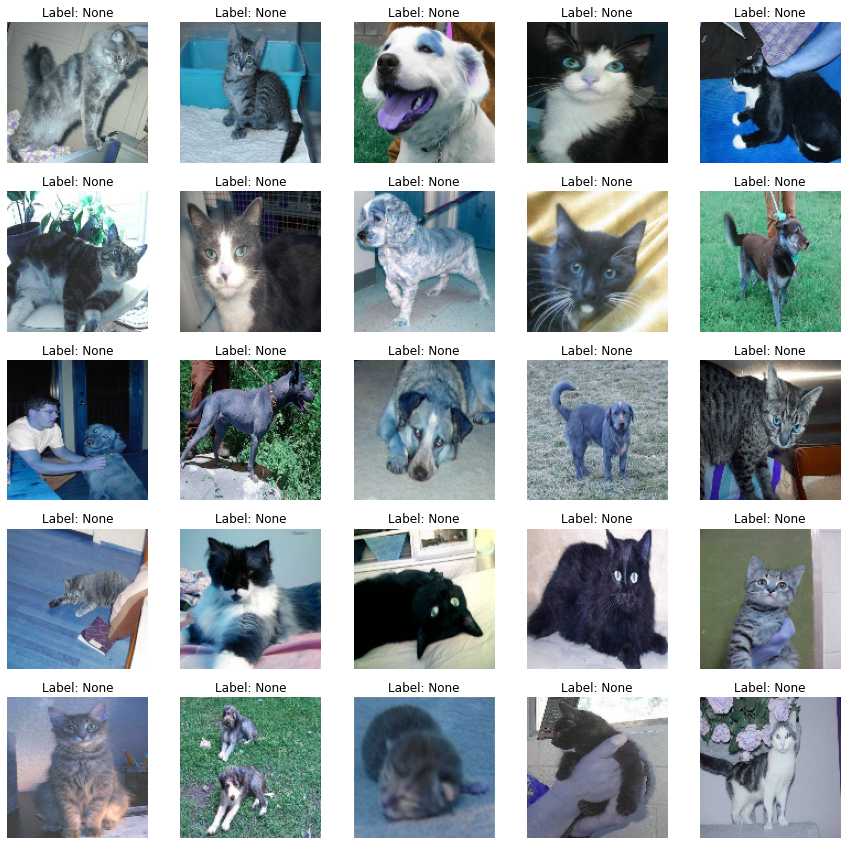

In [ ]:
show_images(test,True)

# <a id="5">Preparing train and test data</a>


In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

### Split the train data in train and validation

We split the train data in two parts. One will be reserved for train set, the second for validation set. Only the train subset of the data will be used for training the model; the validation set will be used for validation, during training.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# <a id="5">Model InceptionV3</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = Sequential()
model.add(InceptionV3(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

87924736/87910968 [==============================] - 2s 0us/step


### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [ ]:
input_shape = X.shape  
model.build(input_shape) 
model.summary()
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (25000, 2048)             21802784  
_________________________________________________________________
dense (Dense)                (25000, 2)                4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [ ]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=5,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
196/196 [==============================] - 52s 215ms/step - loss: 0.3865 - accuracy: 0.8217 - val_loss: 0.2960 - val_accuracy: 0.8890
Epoch 2/5
196/196 [==============================] - 39s 198ms/step - loss: 0.1492 - accuracy: 0.9422 - val_loss: 0.2090 - val_accuracy: 0.9186
Epoch 3/5
196/196 [==============================] - 40s 206ms/step - loss: 0.0627 - accuracy: 0.9794 - val_loss: 0.2048 - val_accuracy: 0.9248
Epoch 4/5
196/196 [==============================] - 38s 196ms/step - loss: 0.0289 - accuracy: 0.9914 - val_loss: 0.2062 - val_accuracy: 0.9274
Epoch 5/5
196/196 [==============================] - 38s 196ms/step - loss: 0.0162 - accuracy: 0.9958 - val_loss: 0.2315 - val_accuracy: 0.9282


## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

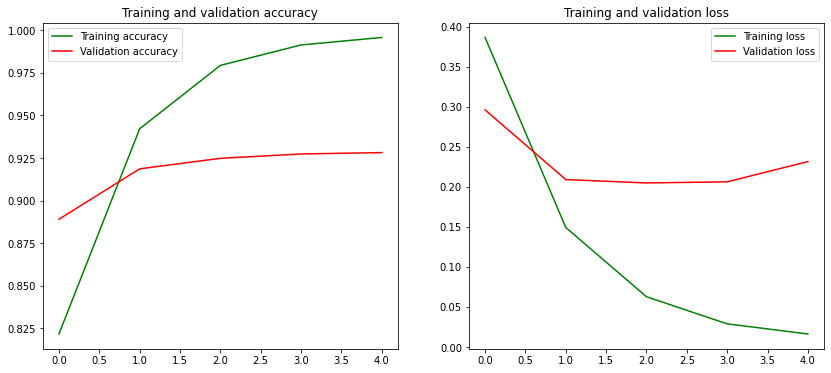

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.2314532995223999
Validation accuracy: 0.9281600117683411


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.94      0.92      0.93      6239
    Class 1:       0.92      0.94      0.93      6261

    accuracy                           0.93     12500
   macro avg       0.93      0.93      0.93     12500
weighted avg       0.93      0.93      0.93     12500



# <a id="6">Prepare the submission InceptionV3</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


Consider rewriting this model with the Functional API.


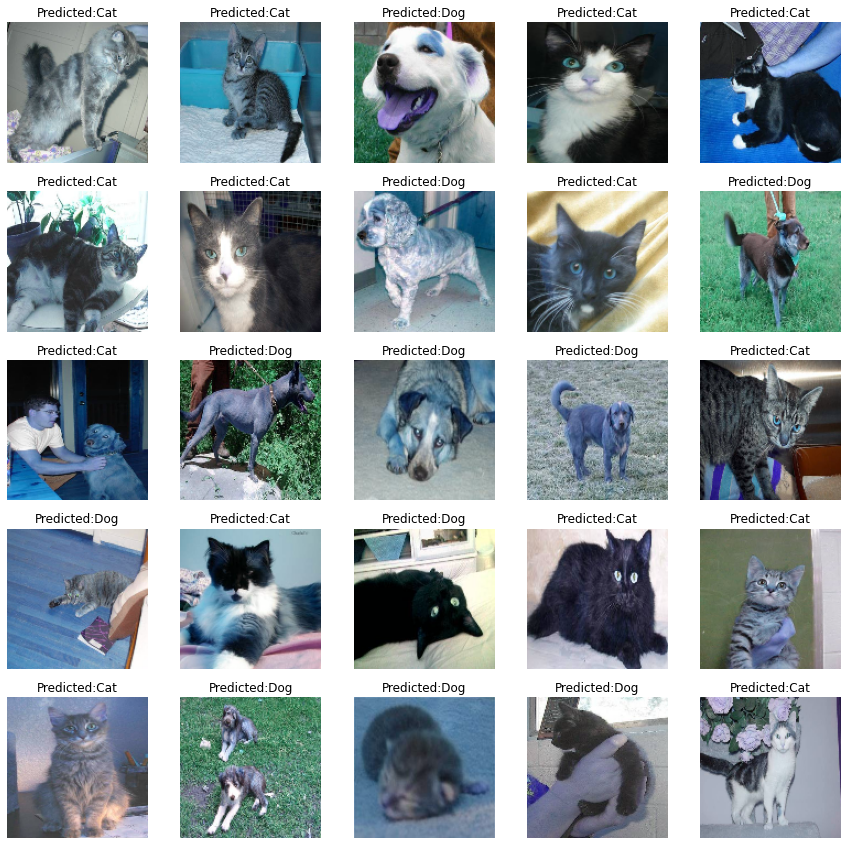

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

### Test data prediction

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

### Submission file

Let's prepare now the submission file.

In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission.csv", index=False)

# <a id="5">Model ResNet50</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [ ]:
tf.keras.backend.clear_session()

### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [ ]:
input_shape = X.shape  
model.build(input_shape) 
model.summary()
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (25000, 2048)             23587712  
_________________________________________________________________
dense (Dense)                (25000, 2)                4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [ ]:
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=5,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
196/196 [==============================] - 61s 276ms/step - loss: 0.7638 - accuracy: 0.9159 - val_loss: 0.2891 - val_accuracy: 0.8903
Epoch 2/5
196/196 [==============================] - 62s 317ms/step - loss: 0.0585 - accuracy: 0.9806 - val_loss: 0.1510 - val_accuracy: 0.9554
Epoch 3/5
196/196 [==============================] - 54s 273ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 0.1364 - val_accuracy: 0.9618
Epoch 4/5
196/196 [==============================] - 53s 272ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.1473 - val_accuracy: 0.9646
Epoch 5/5
196/196 [==============================] - 62s 316ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.1501 - val_accuracy: 0.9623


## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

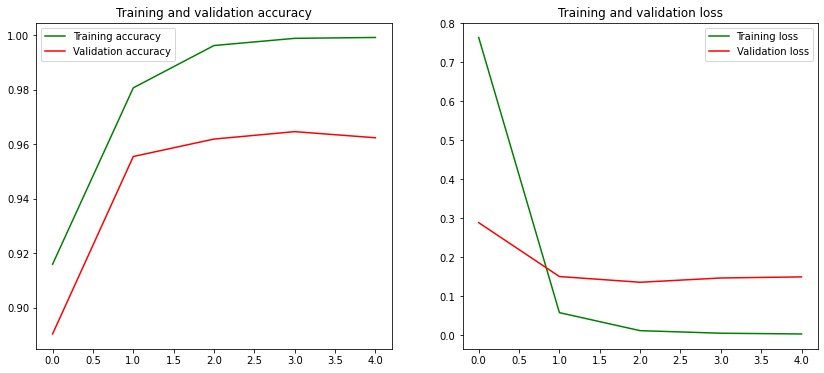

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.1501338630914688
Validation accuracy: 0.9623200297355652


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.95      0.97      0.96      6239
    Class 1:       0.97      0.95      0.96      6261

    accuracy                           0.96     12500
   macro avg       0.96      0.96      0.96     12500
weighted avg       0.96      0.96      0.96     12500



# <a id="6">Prepare the submission ResNet50</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


Consider rewriting this model with the Functional API.


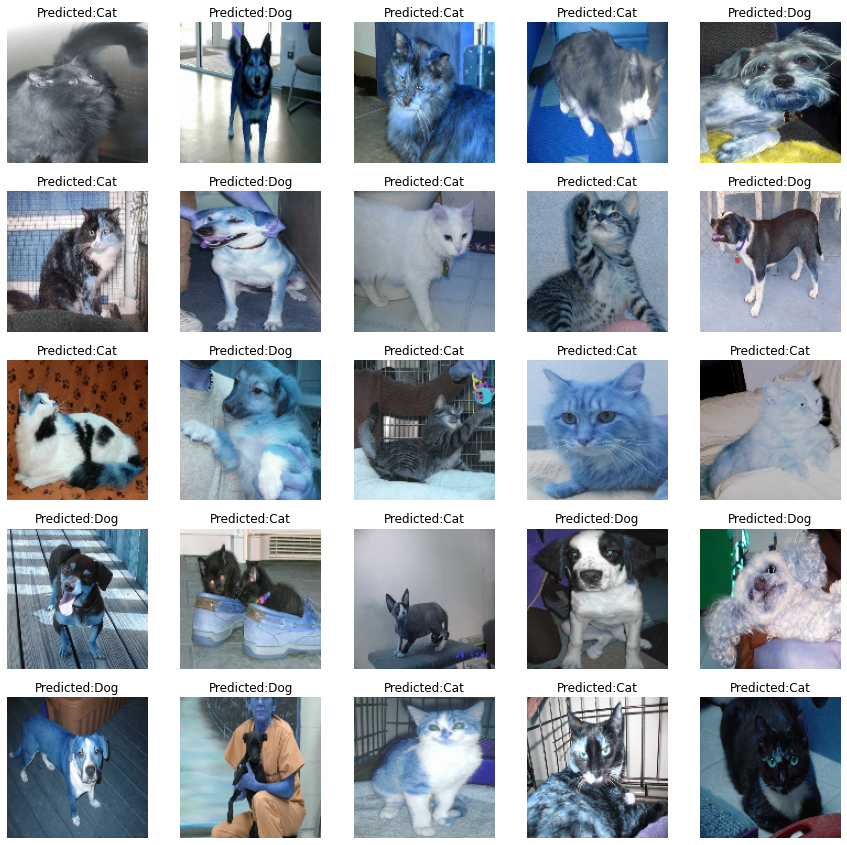

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

### Test data prediction

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

### Submission file

Let's prepare now the submission file.

In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission.csv", index=False)

# <a id="5">Model ResNet50 + 64 Extra Layer Dense </a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [ ]:
tf.keras.backend.clear_session()

### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [ ]:
input_shape = X.shape  
model.build(input_shape) 
model.summary()
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (25000, 2048)             23587712  
_________________________________________________________________
dense (Dense)                (25000, 64)               131136    
_________________________________________________________________
dense_1 (Dense)              (25000, 2)                130       
Total params: 23,718,978
Trainable params: 23,665,858
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [ ]:
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=5,
                  verbose=1,
                  validation_data=(X_val, y_val),
                  # callbacks=[callbacks]
                  )

Epoch 1/5
196/196 [==============================] - 62s 277ms/step - loss: 0.3436 - accuracy: 0.9154 - val_loss: 0.1286 - val_accuracy: 0.9524
Epoch 2/5
196/196 [==============================] - 53s 272ms/step - loss: 0.0355 - accuracy: 0.9879 - val_loss: 0.2198 - val_accuracy: 0.9288
Epoch 3/5
196/196 [==============================] - 53s 273ms/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 0.1403 - val_accuracy: 0.9567
Epoch 4/5
196/196 [==============================] - 53s 272ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.1447 - val_accuracy: 0.9575
Epoch 5/5
196/196 [==============================] - 53s 273ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.2639 - val_accuracy: 0.9354


## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

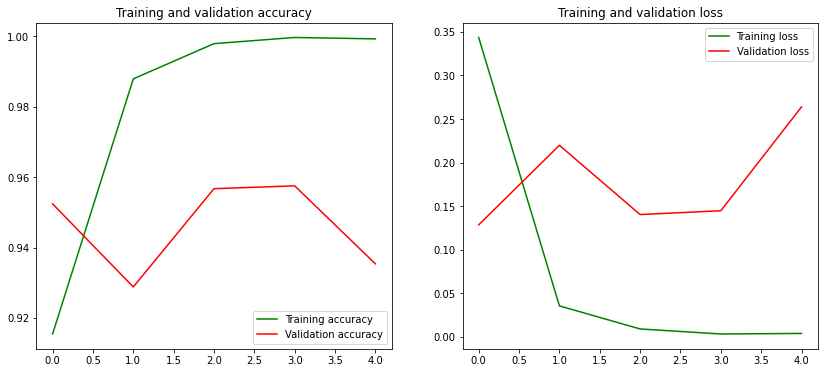

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.26390916109085083
Validation accuracy: 0.9353600144386292


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.89      0.99      0.94      6239
    Class 1:       0.99      0.88      0.93      6261

    accuracy                           0.94     12500
   macro avg       0.94      0.94      0.94     12500
weighted avg       0.94      0.94      0.94     12500



# <a id="5">Model ResNet50 + 1024 Extra Layer Dense + Dropouts </a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [ ]:
tf.keras.backend.clear_session()

### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [ ]:
input_shape = X.shape  
model.build(input_shape) 
model.summary()
#model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (25000, 2048)             23587712  
_________________________________________________________________
module_wrapper_5 (ModuleWrap (25000, 2048)             0         
_________________________________________________________________
dense_4 (Dense)              (25000, 1024)             2098176   
_________________________________________________________________
dense_5 (Dense)              (25000, 2)                2050      
Total params: 25,687,938
Trainable params: 25,634,818
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [ ]:
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=5,
                  verbose=1,
                  validation_data=(X_val, y_val)
                  )

Epoch 1/5
196/196 [==============================] - 70s 322ms/step - loss: 0.5682 - accuracy: 0.9245 - val_loss: 0.1355 - val_accuracy: 0.9496
Epoch 2/5
196/196 [==============================] - 63s 319ms/step - loss: 0.0381 - accuracy: 0.9858 - val_loss: 0.1160 - val_accuracy: 0.9598
Epoch 3/5
196/196 [==============================] - 54s 276ms/step - loss: 0.0099 - accuracy: 0.9974 - val_loss: 0.1144 - val_accuracy: 0.9639
Epoch 4/5
196/196 [==============================] - 54s 273ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.1199 - val_accuracy: 0.9642
Epoch 5/5
196/196 [==============================] - 54s 274ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.1210 - val_accuracy: 0.9652


## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

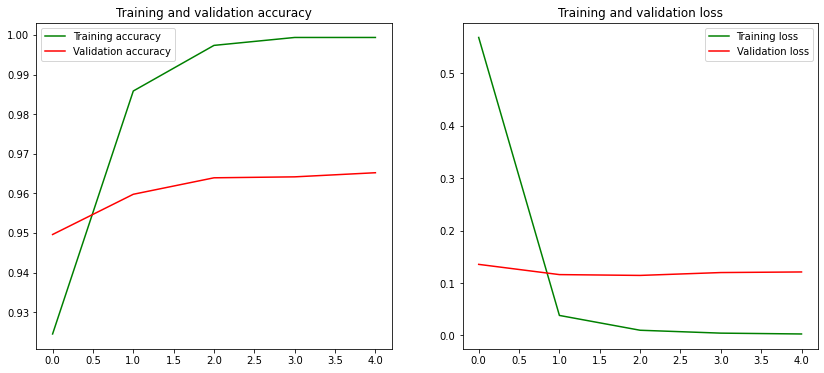

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.12104056030511856
Validation accuracy: 0.9652000069618225


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.96      0.97      0.97      6239
    Class 1:       0.97      0.96      0.97      6261

    accuracy                           0.97     12500
   macro avg       0.97      0.97      0.97     12500
weighted avg       0.97      0.97      0.97     12500



Consider rewriting this model with the Functional API.


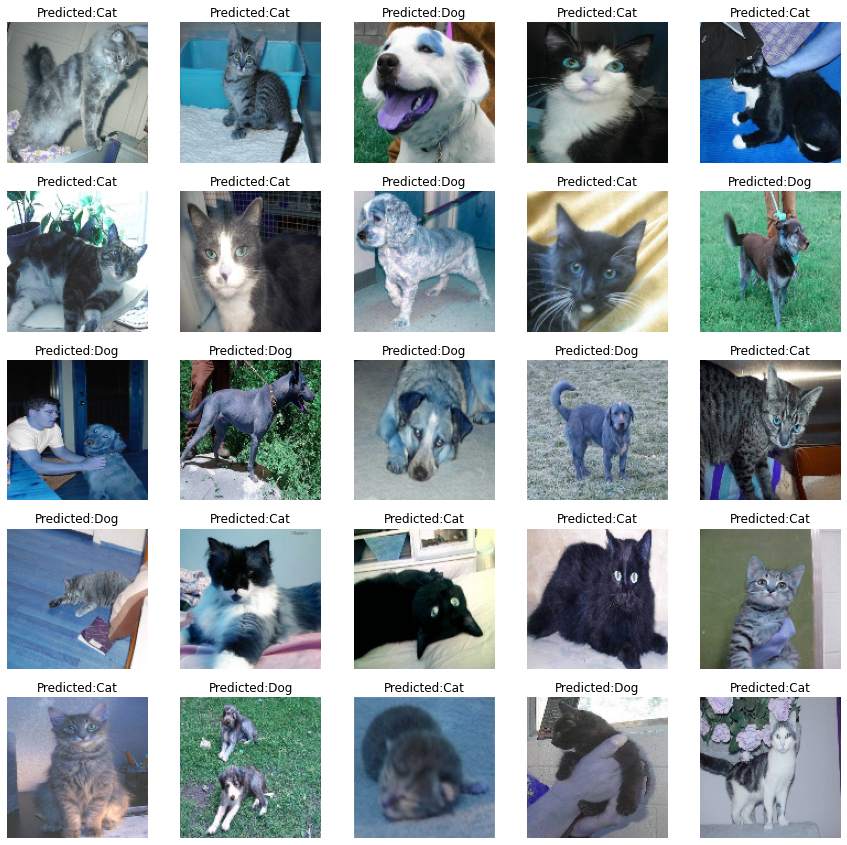

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/dataset-cat-dog-25k') 

# <a id="5">Model ResNet50V2</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [ ]:
tf.keras.backend.clear_session()

### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
model = Sequential()
model.add(ResNet50V2(include_top=False, pooling='max', weights='imagenet'))

model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [ ]:
input_shape = X.shape  
model.build(input_shape) 
model.summary()
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (25000, 2048)             23564800  
_________________________________________________________________
dense (Dense)                (25000, 2)                4098      
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [ ]:
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=4,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/4
196/196 [==============================] - 55s 260ms/step - loss: 0.4165 - accuracy: 0.8877 - val_loss: 0.2920 - val_accuracy: 0.9118
Epoch 2/4
196/196 [==============================] - 49s 249ms/step - loss: 0.0624 - accuracy: 0.9792 - val_loss: 0.1872 - val_accuracy: 0.9337
Epoch 3/4
196/196 [==============================] - 58s 298ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.2062 - val_accuracy: 0.9354
Epoch 4/4
196/196 [==============================] - 49s 250ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.2055 - val_accuracy: 0.9407


## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

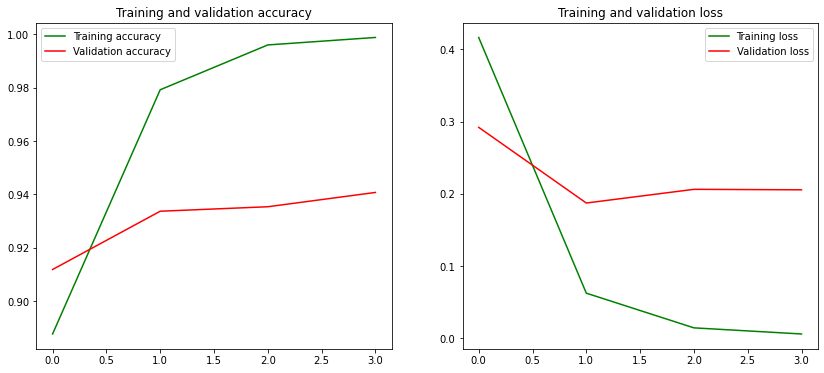

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.20553816854953766
Validation accuracy: 0.9407200217247009


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

# <a id="6">Prepare the submission ResNet50V2</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


Consider rewriting this model with the Functional API.


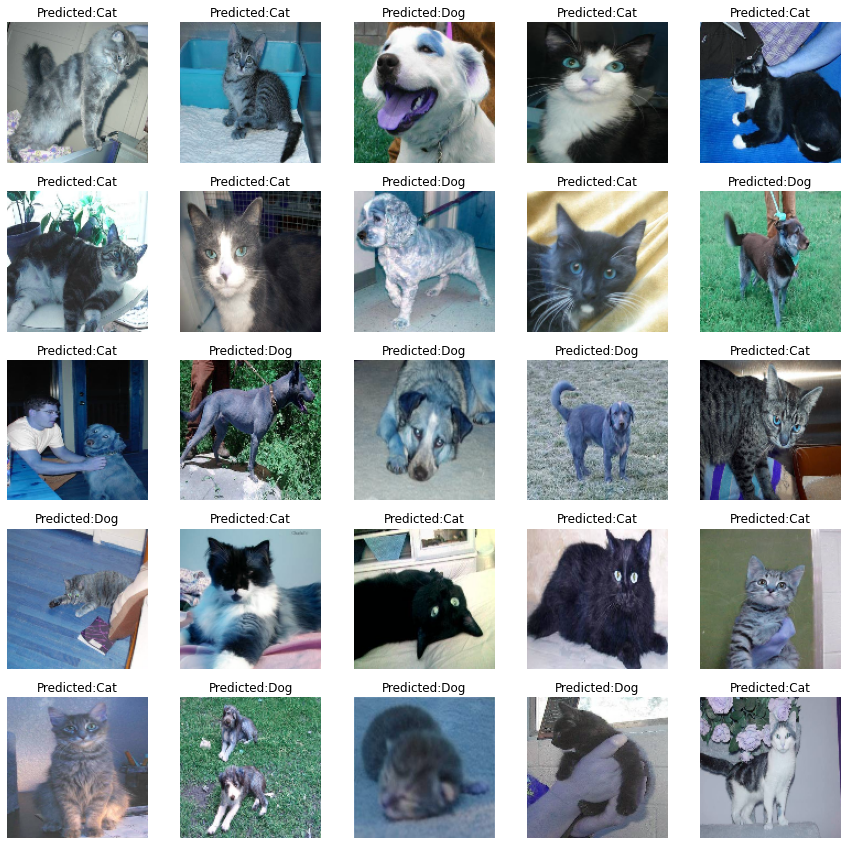

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

# <a id="5">Model EfficientNetB1</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [ ]:
tf.keras.backend.clear_session()

### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
model = Sequential()
model.add(EfficientNetB1(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

27033600/27018416 [==============================] - 0s 0us/step


### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [ ]:
input_shape = X.shape  
model.build(input_shape) 
model.summary()
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (25000, 1280)             6575239   
_________________________________________________________________
dense (Dense)                (25000, 2)                2562      
Total params: 6,577,801
Trainable params: 6,515,746
Non-trainable params: 62,055
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [ ]:
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=8,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/8
196/196 [==============================] - 81s 338ms/step - loss: 0.6719 - accuracy: 0.8458 - val_loss: 0.4191 - val_accuracy: 0.8889
Epoch 2/8
196/196 [==============================] - 63s 320ms/step - loss: 0.2104 - accuracy: 0.9292 - val_loss: 0.6384 - val_accuracy: 0.8498
Epoch 3/8
196/196 [==============================] - 63s 320ms/step - loss: 0.1143 - accuracy: 0.9571 - val_loss: 0.3166 - val_accuracy: 0.9062
Epoch 4/8
196/196 [==============================] - 62s 319ms/step - loss: 0.0847 - accuracy: 0.9669 - val_loss: 0.1734 - val_accuracy: 0.9417
Epoch 5/8
196/196 [==============================] - 62s 318ms/step - loss: 0.0651 - accuracy: 0.9753 - val_loss: 0.2982 - val_accuracy: 0.9150
Epoch 6/8
196/196 [==============================] - 62s 319ms/step - loss: 0.0464 - accuracy: 0.9814 - val_loss: 0.1804 - val_accuracy: 0.9463
Epoch 7/8
196/196 [==============================] - 73s 371ms/step - loss: 0.0402 - accuracy: 0.9851 - val_loss: 0.1635 - val_accuracy:

## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

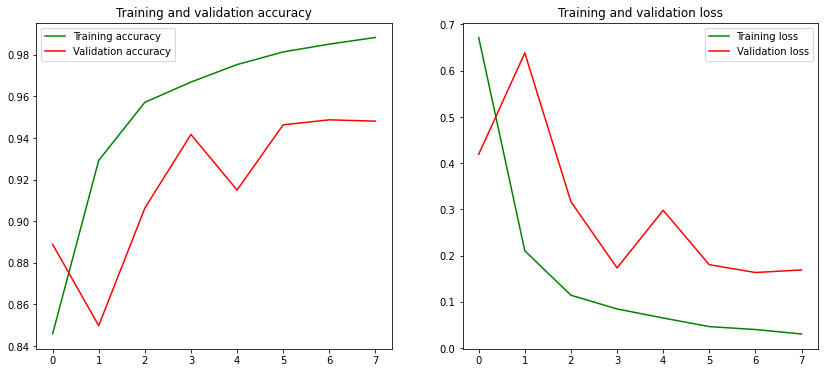

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.16905562579631805
Validation accuracy: 0.9480800032615662


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

# <a id="6">Prepare the submission EfficientNetB1</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


Consider rewriting this model with the Functional API.


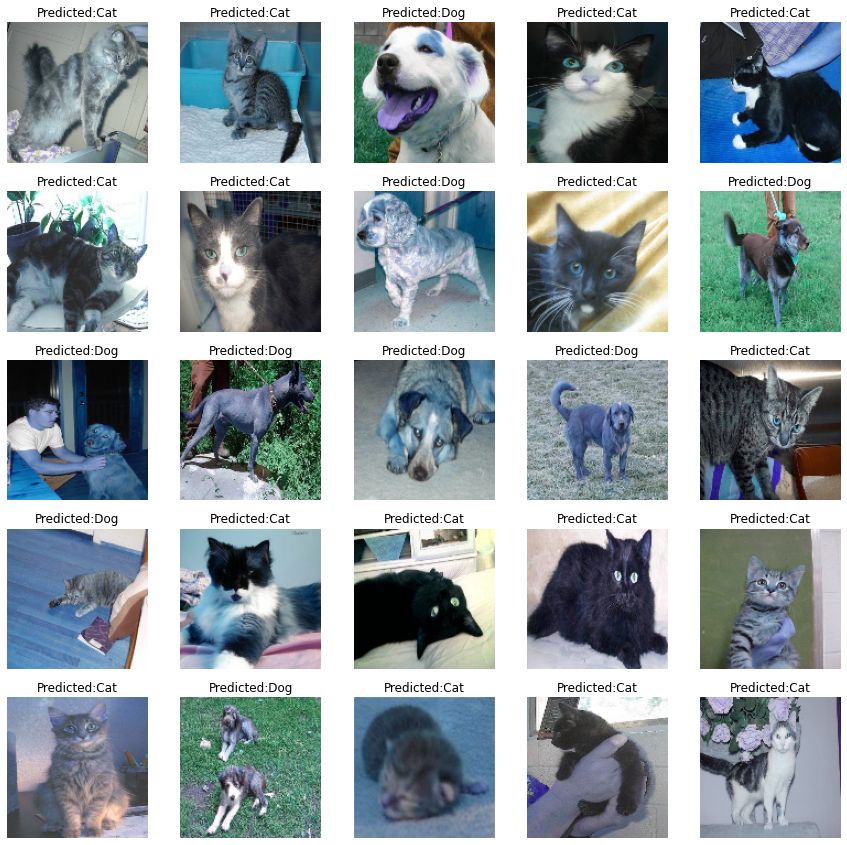

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

### Test data prediction

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

### Submission file

Let's prepare now the submission file.

In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission.csv", index=False)

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

# <a id="7">Conclusions</a>

Using a pretrained model for Keras, ResNet-50, with a Dense model with softmax activation added on top and training with a reduced set of  we were able to obtain quite good model in terms of validation accuracy.   
The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.  


# <a id="8">References</a>

[1] Cats or Dogs - using CNN with Transfer Learning: https://www.kaggle.com/code/gpreda/cats-or-dogs-using-cnn-with-transfer-learning/notebook 

[2] Dogs vs. Cats Redux: Kernels Edition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition  
[3] ResNet pretrained models for Keras, https://www.kaggle.com/keras/resnet50  



